# Portfolio Task 5: Cluster Analysis

## Introduction

A study on behalf of a business analytics consultancy company that has recently signed a contract with a UK bank to undertake segmentation analysis to identify trends and patterns in a sample of records collected from a number of their customers. 

The segments can be later used for the development of segment-specific financial products and promotions. 

**The data:** 
- Information on the customers’ `gender`, `age`, `savings` and `current account balances`, `marital status`, `homeownership` and `employability`. 
- Information on `how long they have been customers` with the bank, `how long they have been in employment` as well as their `credit risk`. 

## Key Findings

In this case, `Hierarchical Clustering` is the effective clustering technique for targeting financial products and promotions.

The analysis indicates `two distinct customer groups` with varying financial profiles and product needs.
- `Cluster 0`, with a more established financial position, is best suited for long-term investment and insurance products.
- `Cluster 1`, being younger and less financially mature, would benefit from products that cater to short-term needs and help them build financial security.

## Recommendations

**Cluster 0: Older, High-Savings Customers**

- This cluster consists of older customers with `high savings`, `long-term employment`, and a `higher percentage in management positions`. 
- Their financial stability and long-term outlook make them more inclined towards long-term investment products like bonds, stocks, and mutual funds. 
- Additionally, they are likely to be interested in life insurance or property insurance products, given their focus on securing their financial future and wealth preservation.

**Cluster 1: Younger, Low-Savings Customers**

- This majority of customer group represents younger customers with `lower savings`, `higher balances` in their current accounts for day-to-day spending, and `limited work experience`. 
- Due to their current financial situation, this cluster is more suited for credit cards, unsecured small loans, and short-term financial products. 
- However, they may also have an interest in exploring more flexible savings or investment options that help them build a foundation for future financial growth.

## Tasks
[1. Appropriate methods to apply for the market segmentation.The characteristics used for cluster analysis and necessary modifications to the dataset to conduct the cluster analysis.](#5_1) 

[2. Apply, compare and contrast two different clustering algorithms. A short report summarising findings, providing an overview of the different clusters and all necessary steps undertaken in the analysis.](#5_2)

## The Project Directory

The Portfolio 5 Project files can be found in the Github Repository: [github.com/lamtong/portfolio5_cluster_analysis](https://github.com/lamtong/portfolio5_cluster_analysis)

## I. Data Pre-Processing

In [59]:
# Import packages
import pandas as pd
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

sys.path.append(os.path.abspath(".."))
from shared_files.custom_plots import plot_props  # Import the customise plot module

import warnings
# Ignore FutureWarnings
warnings.filterwarnings("ignore", 
                        category = FutureWarning)  

# Ignore SettingWithCopyWarning
warnings.simplefilter(action="ignore", 
                      category = pd.errors.SettingWithCopyWarning) 

# Ignore UserWarning
warnings.simplefilter(action="ignore", 
                      category = UserWarning) 

In [60]:
# -- Import the datasets -- 

# Base Data sheet
df_base = pd.read_excel(io         = 'Unit6-Portfolio-Task-Data.xlsx', 
                        sheet_name = 'Base Data',
                        header     = 1)              

# Additional Data sheet (unused)
df_add = pd.read_excel(io         = 'Unit6-Portfolio-Task-Data.xlsx', 
                       sheet_name = 'Additional Data')      

### 1. Nulls and Duplicates handling:
**Missing values:**

In [61]:
# Number of missing data
print(f'Nulls in Base Data:\n{df_base.isna().sum()}\n')

Nulls in Base Data:
Current Account    0
Savings Account    0
Months Customer    0
Months Employed    0
Gender             0
Marital Status     0
Age                0
Housing            0
Job                0
Credit Risk        0
dtype: int64



**Duplicated Values:**

In [62]:
# Duplicates checking
print(f'Duplicated in Base Data: {df_base.duplicated().sum()}')

Duplicated in Base Data: 0


### 2. Unique Categorical values:

**Unique labels in the each column:**

In [63]:
base_cat = ['Gender', 'Marital Status', 'Housing', 
            'Job', 'Credit Risk'] # Base Data Categoricals

# Show Base Data uniques in each column
print('Base Data Categorical Values:')
for col in df_base[base_cat]:
    print(col, df_base[col].unique())

Base Data Categorical Values:
Gender ['M' 'F']
Marital Status ['Single' 'Divorced' 'Married']
Housing ['Own' 'Rent' 'Other']
Job ['Unskilled' 'Skilled' 'Management' 'Unemployed']
Credit Risk ['Low' 'High']


## II. Portfolio 5 Tasks

<a name="5_1"></a>
### 1. Appropriate methods  to apply for the market segmentation. The characteristics used for cluster analysis, and modifications to the dataset to conduct the cluster analysis.

#### Methods to apply for the Market Segmentation:
To develop segment-specific products and promotions for the bank, we need to group customers based on their characteristics. The following techniques will be used in the cluster analysis:

- `Hierachical Clustering`: Builds a tree-like structure to form clusters by merging or splitting groups. Suitable for small to medium datasets, exploratory analysis. Higher Computational cost than K-means (more sensitive to high dimensionality).
- `K-means Clustering`: Partitions data into a predefined number of clusters by minimising the distance from centroids. Suitable for large datasets, well-separated clusters. Tends to form spherical clusters.

#### The characteristics used for Cluster Analysis:

- The Goal of the Cluster Analysis is to find the underlying patterns in the Bank's customers, in order to develop a segment-specific financial products and promotions. 

- Therefore, to ensure identifying the appropriate clusters of customers with same interest and financial background, the Cluster Analysis uses all available and variables in the *Base Dataset* containing the basic information about customer's demographic and financial status, including: `Current Account`, `Savings Account`, `Months Customer`, `Months Employed`, `Gender`, `Marital Status`, `Age`, `Housing`, `Job`, and `Credit Risk`

#### Modifications for the Cluster Analysis:

**Outliers Handling:**

As the `Hierachical` and `K-means` Clustering Methods rely heavily on distance-based measures to form the clusters, they are sensitive to outliers. 

Thus, it is necessary to handle these outliers (e.g. removal or rescaling) to prevent them distort the clustering result:

- `Current Account` and `Savings Account`: From the plot below, their distributions are right-skewed with numerous extreme outliers. Instead of removing these outliers, which may contain valuable insights, we apply a *log10* transformation to rescale these variables.
- `Months Customer` and `Months Employed`: There are only a few outliers, then we can exclude them to ensure a proper clustering.

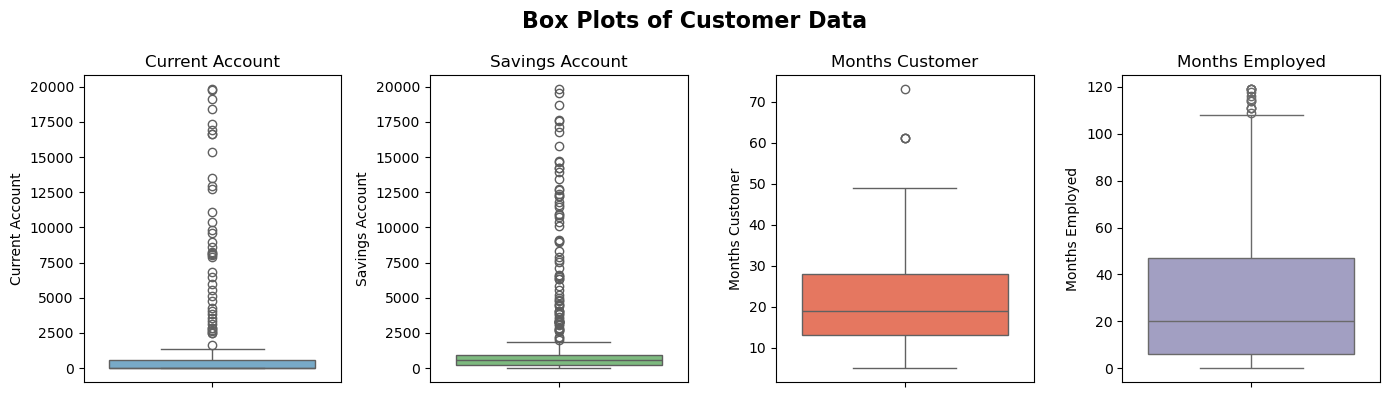

In [64]:
# Create multiple subplots
fig, axes = plt.subplots(1, 4, figsize=(14, 4))

# Define colors for each box plot
colors = ['Blues', 'Greens', 'Reds', 'Purples']

# Box Plots
for i, var in enumerate(['Current Account', 'Savings Account',
                         'Months Customer', 'Months Employed']):
    sns.boxplot(y       = df_base[var], 
                ax      = axes[i],
                palette = colors[i])
    axes[i].set_title(var)

# Set the main title
fig.suptitle('Box Plots of Customer Data', fontsize=16, fontweight='bold')

# Show the plots
plt.tight_layout()
plt.show()

In [65]:
def remove_outliers_iqr(df, column):
    '''This function remove records with extreme outliers
       in a column
    Arguments:
        df -- the designated dataframe
        column -- the designated column

    Returns:
        the dataframe with excluded outliers
    '''
    Q1 = df[column].quantile(0.25)  # 25th percentile
    Q3 = df[column].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile Range
    
    # Define bounds for non-outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out outliers
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

# Apply outlier removal to both columns
df_clean = remove_outliers_iqr(df_base, 'Months Customer')
df_clean = remove_outliers_iqr(df_clean, 'Months Employed') 

# Save the Original Dataset with removed Outlier
# for later intepretation
df_base_clean = df_clean.copy()

In [66]:
# Select only integer columns
outliers_base = ['Current Account', 'Savings Account']

def log_10(data, var):
    '''Log10 transformation

    Arguments:
        data -- the targeted dataframe
        var -- the targeted column
    '''
    data[f'{var}_log'] = np.log10(data[var] + 1)

# Transform the columns
for col in outliers_base:
    log_10(df_clean, col)

**Categorical Variables Handling:**
- `Gender`, `Marital Status`, `Housing`: Use dummy variables, excluding the most popular dummy variables to address redundancy..
- `Job`, `Credit Risk`: Ecoding their labels with a specified order

In [67]:
### Handling the Categorical Varialbes ###

# Define a mapping dictionary
job_mapping    = {'Unskilled': 0, 'Unemployed': 1, 'Skilled': 2, 'Management': 3}
credit_mapping = {'High': 0, 'Low': 1}

# Apply mapping
df_clean['job_encoded']         = df_clean['Job'].map(job_mapping)
df_clean['credit_risk_encoded'] = df_clean['Credit Risk'].map(credit_mapping)

# One-hot Encoding #
df_clean = pd.get_dummies(data       = df_clean, 
                          columns    = ['Gender', 'Marital Status', 'Housing']) 

# Dataset for Clustering
df_clean = df_clean.drop(columns = ['Job', 'Credit Risk',
                                    'Current Account', 'Savings Account'])

# Drop most populular dummy variables to avoid redundancy
df_clean = df_clean.drop(columns = ['Gender_M', 'Marital Status_Single', 'Housing_Own'])

**Redundancy:**

Since all `VIF < 10`, there is no severe multicollinearity among the variables. Thus, the clustering algorithm should perform accurately since the input variables are relatively independent.

In [68]:
# Convert to numeric (force conversion)
df_vif = df_clean.astype(float)

# Calculate VIF for each variable
vif = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

# Count values greater than 10
high_vif = np.sum(np.array(vif) > 10)
print(f'Number of variables with VIF > 10: {high_vif}')

Number of variables with VIF > 10: 0


<a name="5_2"></a>
### 2. Apply, compare and contrast two different clustering algorithms. A short report summarising findings, providing an overview of the different clusters and all necessary steps undertaken in the analysis.

#### 2.1. Hierarchical Clustering:

Hierarchical clustering is an unsupervised learning method for clustering data points. The algorithm builds clusters by measuring the dissimilarities between data.

- Type: Agglomerative - Starts with individual data points and merges the closest clusters at each step.
- Best for: Small to medium-sized datasets, hierarchical relationships between clusters.
- Limitations:
  - Sesitive to outliers and high dimensionality.
  - Not suitable for large datasets.
  - Hard to determine the optimal number of clusters without visualisation (dendrogram).

**The Dedogram:**

- Based on the dendrogram below, the appropriate number of clusters is `2`, as there is a significant vertical gap between the two clusters. 
- This large gap indicates a clear distinction between the clusters, suggesting that they should be considered separate clusters.

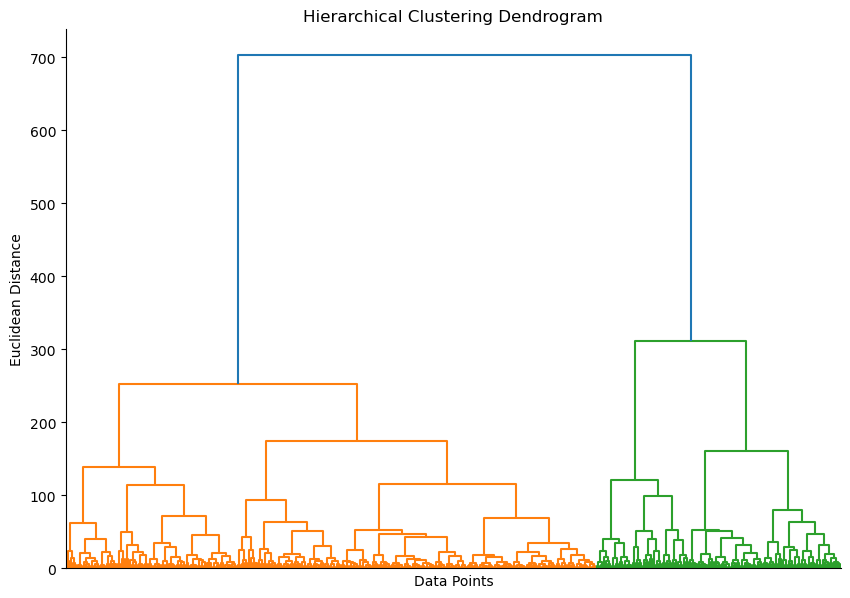

In [69]:
#Create and plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(df_clean, method='ward'))
plt.title("Hierarchical Clustering Dendrogram")
plt.xticks([]) # Disable xticks
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
sns.despine()
plt.show()

**Find the best `Agglomerative Hierarchical Clustering` Method:**

To find the best method, on a random subset of `30%` of the data, try all different combinations of:
- Number of Clusters: `2 to 7` clusters.
- Distance Metric: `Euclidean`, `Manhattan`, and `Cosine`. Unfortunately, `Minkowski` and `Mahalanobis` aren't available in *sklearn.cluster.AgglomerativeClustering*
- Linkage: `Single-link`, `Complete-link`, `Average-link`, and `Ward's`.


In [70]:
# Agglomerative Hierarchical Clustering Parameters
hc_al = {'n_cluster'  : [2, 3, 4, 5, 6, 7],
         'metric'     : ['euclidean', 'manhattan', 'cosine'],
         'linkage'    : ['ward', 'complete', 'average', 'single']}

# The Random Subset of 30% Data
hc_subset = df_clean.sample(frac         = 0.3, 
                            random_state = 42)

# The Dataframe of resuslts
df_hc_al = pd.DataFrame(columns=['Clusters', 'Metric', 'Linkage', 'Silhouette'])

# Perform the Clustering with all combinations
for n_cluster in hc_al['n_cluster']:
    for metric in hc_al['metric']:
        for linkage in hc_al['linkage']:
            
            # Ward's linkage only works with Euclidean Distance 
            if metric != 'euclidean' and linkage == 'ward':
                continue
            else:
                hc = AgglomerativeClustering(n_clusters = n_cluster, 
                                             metric     = metric, 
                                             linkage    = linkage)
                hrc_clusters = hc.fit_predict(hc_subset)
                
                silhouette_avg_hc = silhouette_score(hc_subset, hrc_clusters)
                
                # Create a DataFrame for the new row
                new_row = pd.DataFrame({'Clusters'   : [n_cluster], 
                                        'Metric'     : [metric], 
                                        'Linkage'    : [linkage],
                                        'Silhouette' : [silhouette_avg_hc]})

                # Concatenate the new row to the original DataFrame
                df_hc_al = pd.concat([df_hc_al, new_row], ignore_index=True)

The combinations with the highest Silhouette Score:

In [71]:
# Records of Highest Silhouettes
df_hc_al.nlargest(5, 'Silhouette')

,Clusters,Metric,Linkage,Silhouette
5,2,manhattan,average,0.561143
1,2,euclidean,complete,0.559232
2,2,euclidean,average,0.559232
0,2,euclidean,ward,0.519763
8,2,cosine,average,0.519763


**Based on the results above, the best `Agglomerative Hierachical Clustering` Model:**
- Number of Clusters: `2`
- Distance metric: `Manhattan`
- Linkage method: `average`

In [72]:
### Apply Hierarchical Clustering on the complete dataset###

hc = AgglomerativeClustering(n_clusters = 2, 
                             metric     = 'manhattan', 
                             linkage    = 'average')
hc_clusters = hc.fit_predict(df_clean)

silhouette_avg_hc = silhouette_score(df_clean, hc_clusters)

# Assign cluster labels to a dataset
hc_clus = df_clean.copy()
df_base_clean['hc_cluster'] = hc_clusters

**Cluster Sizes:**

In [73]:
# Number of Customers in each Cluster
clus_size = df_base_clean['hc_cluster'].value_counts()
clus_size = clus_size.to_frame()
clus_size

,count
hc_cluster,
1,320
0,88


**Silhouette Score:**

A Silhouette Score of `0.558` indicates a moderate to good clustering result. It suggests that the clusters are reasonably well-separated, but there's still room for improvement.

In [74]:
# The Silhouette Score
silhouette_avg_hc = silhouette_score(df_clean, hc_clusters)
print(f'Hierachichal Clustering Silhouette Score: {silhouette_avg_hc:.4f}')

Hierachichal Clustering Silhouette Score: 0.5575


**Averages between Clusters:**

The Averages of `Current Account`, `Savings Account`, `Months Customer`, `Months Employed`, and `Age` between Clusters.

In [75]:
def cluster_compare(df, var):
    '''_summary_

    Arguments:
        df -- _description_
        var -- _description_

    Returns:
        _description_
    '''
    # Numerical values
    numericals = ['Current Account', 'Savings Account', 
                'Months Customer', 'Months Employed', 
                'Age']

    # Categorical values
    categoricals = ['Gender', 'Marital Status', 
                    'Housing', 'Job', 'Credit Risk']
    
    # Averages between Clusters
    avg_diff = df.groupby(var)[numericals].mean()
    avg_diff = avg_diff.applymap(lambda x: f"{x:.2f}")

    # Unqiue counts between Clusters
    unique = df.groupby(var)[categoricals].value_counts()

    return avg_diff, unique

hc_mean, hc_unique =  cluster_compare(df_base_clean, 'hc_cluster')

In [76]:
# Averages between Clusters
hc_mean

,Current Account,Savings Account,Months Customer,Months Employed,Age
hc_cluster,,,,,
0,874.75,1982.08,22.15,77.31,41.25
1,1104.85,1750.98,22.52,16.02,32.09


**Percentages of Customers based on their characteristics in each Cluster:**

The percentages of different `Gender`, `Marital Status`, `Housing`, `Job`, `Credit Risk` in each Cluster.

In [77]:
def cluster_percent(df, col):
    '''_summary_

    Arguments:
        df -- _description_
        col -- _description_
    '''

    # Categorical values
    categoricals = ['Gender', 'Marital Status', 
                    'Housing', 'Job', 'Credit Risk']

    # Dictionary to store results
    percentage_results = {}

    # Loop through categorical variables and calculate percentages
    for cat in categoricals:
        percentage_results[cat] = (
            df[[cat, col]]
            .groupby(col)[cat]
            .value_counts(normalize=True) * 100
        )
        
    # Display all results
    for cat, result in percentage_results.items():
        print(f"### Percentage Distribution for {cat} ###")
        print(result.apply(lambda x: f"{x:.0f}%"), "\n") 
  
# Show the percentages in each Cluster     
cluster_percent(df_base_clean, 'hc_cluster')

### Percentage Distribution for Gender ###
hc_cluster  Gender
0           M         80%
            F         20%
1           M         64%
            F         36%
Name: proportion, dtype: object 

### Percentage Distribution for Marital Status ###
hc_cluster  Marital Status
0           Single            73%
            Divorced          24%
            Married            3%
1           Single            49%
            Divorced          42%
            Married            9%
Name: proportion, dtype: object 

### Percentage Distribution for Housing ###
hc_cluster  Housing
0           Own        64%
            Other      22%
            Rent       15%
1           Own        71%
            Rent       21%
            Other       9%
Name: proportion, dtype: object 

### Percentage Distribution for Job ###
hc_cluster  Job       
0           Skilled       59%
            Management    23%
            Unskilled     18%
1           Skilled       65%
            Unskilled     22%
           

**The Clusters Summary:**

| Attribute                              | Cluster 0                                      | Cluster 1                         |
|----------------------------------------|------------------------------------------------|-----------------------------------|
| **Size**                               | 88                                             | 320                               |  
| **Current Account**                    |                                                | Significantly Higher              |
| **Savings Account**                    | Higher                                         |                                   |
| **Months Employed**                    | Significantly Higher                           |                                   |
| **Age**                                | Higher                                         |                                   |  
| **Marital Status**                     | 73% Single                                     | 49% Single                        |
| **Job**                                | 59% Skilled, 23% Management                    | 65% Skilled, 9% Management        |

*For better intepretation of the differences between clusters, further statistical tests should also be considered (e.g. two-sample t-test for means of subsets, or chi-squared test for distributions of categorical variables).*

**Recommendations:**
- **Cluster 0:** This group represents older customers with high savings, long employment tenure, and a higher proportion of management positions. Then they are more likely to intest in long-term investment products such as bonds, stocks, or mutual funds. Or products like Life or Property Insurance, given their financial stability and long-term outlook.
- **Cluster 1:**  Younger customers with low savings and a high balance in their current accounts for spending, along with limited work experience. Products like credit cards and unsecured small loans should be their priority. However, this group may also be interested in exploring flexible savings or investment options that align with their current financial status.

#### 2.2. K-Means Clustering
- Type: Partition-based
  - Divides the dataset into K clusters by minimizing the distance between points within each cluster
  - Each cluster is represented by a central point (centroid)
- Best for: Large datasets with well-separated clusters
- Limitations:
  - Assumes clusters are spherical and similar in size
  - Struggles with non-linear shapes or outliers

**Elbow Method to choose the number of Clusters:**

Based on the *Number of Clusters vs. WCSS* plot, the appropriate number of clusters is `2`, as the plot shows a clear "elbow" at this point, indicating that adding more clusters results in only a small reduction in Within-Cluster Sum of Squares (WCSS).

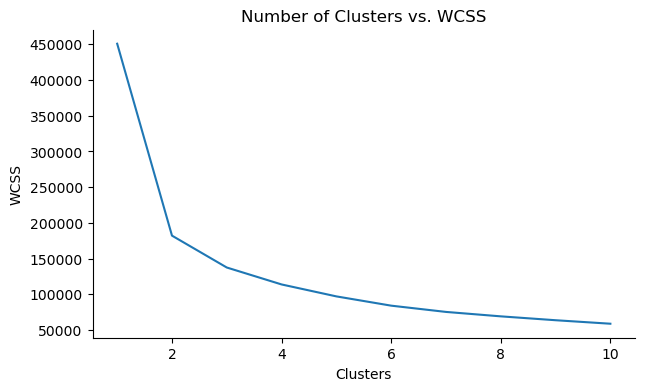

In [78]:
### Determine the number of clusters (using Elbow method) ###

wcss = []  # Within-cluster sum of squares (WCSS)
for i in range(1, 11):  # Cluster sizes from 1 to 10
    kmeans = KMeans(n_clusters   = i, 
                    init         = 'k-means++', 
                    max_iter     = 300, 
                    n_init       = 10, 
                    random_state = 42)
    
    kmeans.fit(df_clean)  # Fit the KMeans algorithm
    wcss.append(kmeans.inertia_)

#Plot the Elbow curve to choose the optimal number of clusters
plt.figure(figsize = (7, 4))
plt.plot(range(1, 11), wcss)
plt.title('Number of Clusters vs. WCSS')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
sns.despine()
plt.show()

**K-means Clustering on the Dataset:**

- Number of Cluster: `2`
- Centroid initialisation: `k-means++` method, improving convergence and accuracy.
- Maximum iterations: `300` iterations to find optimal centroids.
- Number of centroid initialisations: Automatically determines the number of centroid initialisations to improve stability.
- Stopping tolerance: `1e-7` The algorithm stops when the centroid movement is smaller than this value.

In [79]:
optimal_k = 2 # Number of Clusters

# K-Means clustering settings
kmeans = KMeans(n_clusters   = optimal_k, 
                init         = 'k-means++', 
                max_iter     = 300, 
                n_init       = 'auto', 
                random_state = 42,
                tol          = 1e-7)

# Perform clustering
kmean_clusters = kmeans.fit_predict(df_clean)  

# Assign the cluster labels 
df_base_clean['kmean_cluster'] = kmean_clusters

**Cluster Sizes:**

In [ ]:
# Number of Customers in each Cluster
df_km_clus_size = df_base_clean['kmean_cluster'].value_counts()
df_km_clus_size = df_km_clus_size.to_frame()
df_km_clus_size

,count
kmean_cluster,
0,306
1,102


**Silhouette Score:**

A Silhouette Score of `0.549` indicates a moderate to good clustering result, marginally lower than Hierachical Method's above. Still, it suggests that the clusters are reasonably well-separated, but there's still room for improvement. 

In [ ]:
silhouette_avg_kmean = silhouette_score(df_clean, kmean_clusters)
print(f'K-means Clustering Silhouette Score: {silhouette_avg_kmean:.4f}')

K-means Clustering Silhouette Score: 0.5490


**Averages between Clusters:**

The Averages of `Current Account`, `Savings Account`, `Months Customer`, `Months Employed`, and `Age` between Clusters.

In [ ]:
# Averages between Clusters
kmean_mean, kmean_unique =  cluster_compare(df_base_clean, 'kmean_cluster')
kmean_mean

,Current Account,Savings Account,Months Customer,Months Employed,Age
kmean_cluster,,,,,
0,1033.60,1764.81,22.07,14.54,32.18
1,1120.07,1908.87,23.55,73.32,39.74


**Percentages of Customers based on their characteristics in each Cluster:**

The Percentage of different `Gender`, `Marital Status`, `Housing`, `Job`, `Credit Risk` in each Cluster.

In [83]:
# Show the percentages for each Cluster
cluster_percent(df_base_clean, 'kmean_cluster')

### Percentage Distribution for Gender ###
kmean_cluster  Gender
0              M         63%
               F         37%
1              M         79%
               F         21%
Name: proportion, dtype: object 

### Percentage Distribution for Marital Status ###
kmean_cluster  Marital Status
0              Single            47%
               Divorced          43%
               Married           10%
1              Single            74%
               Divorced          24%
               Married            3%
Name: proportion, dtype: object 

### Percentage Distribution for Housing ###
kmean_cluster  Housing
0              Own        71%
               Rent       21%
               Other       8%
1              Own        64%
               Other      21%
               Rent       16%
Name: proportion, dtype: object 

### Percentage Distribution for Job ###
kmean_cluster  Job       
0              Skilled       64%
               Unskilled     23%
               Management     9%
  

**The Clusters Summary:**

| Attribute                              | Cluster 0                                      | Cluster 1                         |
|----------------------------------------|------------------------------------------------|-----------------------------------|
| **Size**                               | 306                                            | 102                               |  
| **Age**                                |                                                | Higher                            |
| **Savings Account**                    |                                                | Slightly Higher                   |
| **Months Employed**                    |                                                | Significantly Higher              |  
| **Job**                                | 9% Management                                  | 22% Management                    |

#### 2.3 Comparing the two Clustering Technique results:

The results' comparison between `Hierachical Clustering` and `K-means Clustering`:

|                                        | Hierarchical Clustering                        | K-means Clustering               |
|----------------------------------------|------------------------------------------------|----------------------------------|
| **Best for**                           | Small to medium-sized datasets, hierarchical relationships between clusters. | Large datasets with well-separated clusters | 
| **Limitations**                        | Sesitive to outliers and high dimensionality. Not suitable for large datasets. | Struggles with non-linear shapes or outliers |
| **Cluster Sizes**                      | 88 - 320                                       | 306 - 102                        |  
| **Silhouette Score**                   | 0.558 (Better)                                 | 0.549                            |
| **Cluster Interpretation**             | Based on the analysis above, this method shows clearer patterns in customer characteristics between clusters, making it more convenient to make business decisions regarding targeted products and promotions | This technique shows less distinct differences between the clusters' characteristics, making it harder to differentiate between customer segments and making relevant decisions                                 |

**Conclusion:** Based on the higher Silhouette Score and clearer clustering patterns, in this case, `Hierarchical Clustering` is the more effective clustering technique for targeting financial products and promotions.